# 

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from notears.linear import notears_linear
import cdt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
# Simulate linear SEM with Gaussian noise
def simulate_linear_sem(G, n=1000, noise_scale=1.0, noise_fn=None):
    d = G.shape[0] # Dimensions of adjacency matrix i.e how many variables there are in the DAG
    X = np.zeros((n, d)) # Create sample matrix where each row (n such rows) is one sample
    
    ordering = list(nx.topological_sort(nx.DiGraph(G)))

    # Default to Gaussian noise
    if noise_fn is None:
        def noise_fn(n, scale):
            return np.random.normal(scale=scale, size=n)

    # Samples X column by column (variable by variable according to the topological sort)
    for j in ordering:
        parents = np.where(G[:, j] != 0)[0] # For variable j, look in jth column for arrows pointing into it (parents) and store the parent number (corresponds to the row i in the non zero (i,j) entry)
        noise = noise_fn(n, noise_scale)
        if len(parents) > 0:
            X[:, j] = X[:, parents].dot(G[parents, j]) + noise
        else:
            X[:, j] = noise
    return X

# Plotting function
def plot_graph(B, title):
    G = nx.DiGraph(B)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=1500, node_color="lightblue", arrowsize=20)
    plt.title(title)
    plt.show()

# Run NOTEARS on graph and print results
def test_notears(G, n, noise=1.0, visual=True):
    X = simulate_linear_sem(G, n, noise_scale=noise)

    # Run NOTEARS
    G_est = notears_linear(X, lambda1=0.1, loss_type='l2')

    # Threshold small weights to force adjacency matrix
    G_adj_est = (np.abs(G_est) > 1e-3).astype(int)

    G_graph = nx.DiGraph(G)
    G_est_graph = nx.DiGraph(G_adj_est)

    GED = nx.graph_edit_distance(G_graph, G_est_graph)
    SHD = cdt.metrics.SHD(G_graph, G_est_graph)

    print("True DAG:\n", G)
    print("Estimated DAG with " + str(n) + " samples:\n", G_adj_est)

    print("Graph Edit Distance (GED) of: " + str(GED))
    print("Structural Hamming Distance (SHD) of: " + str(SHD))

    if visual == True:
        plot_graph(G, "True DAG")
        plot_graph(G_adj_est, "Estimated DAG with " + str(n) + " samples")

    if SHD == 0:
        return True
    else:
        return False

In [4]:
# X1 -> X2 -> X3, and X1 -> X3
test_graph = np.array([[0, 1, 1],
                   [0, 0, 1],
                   [0, 0, 0]])
print(test_notears(test_graph, 10, 3.0, False))
test_notears(test_graph, 2000, 3.0, False)

True DAG:
 [[0 1 1]
 [0 0 1]
 [0 0 0]]
Estimated DAG with 10 samples:
 [[0 1 1]
 [0 0 1]
 [0 0 0]]
Graph Edit Distance (GED) of: 0.0
Structural Hamming Distance (SHD) of: 0
True
True DAG:
 [[0 1 1]
 [0 0 1]
 [0 0 0]]
Estimated DAG with 2000 samples:
 [[0 1 1]
 [0 0 1]
 [0 0 0]]
Graph Edit Distance (GED) of: 0.0
Structural Hamming Distance (SHD) of: 0


True

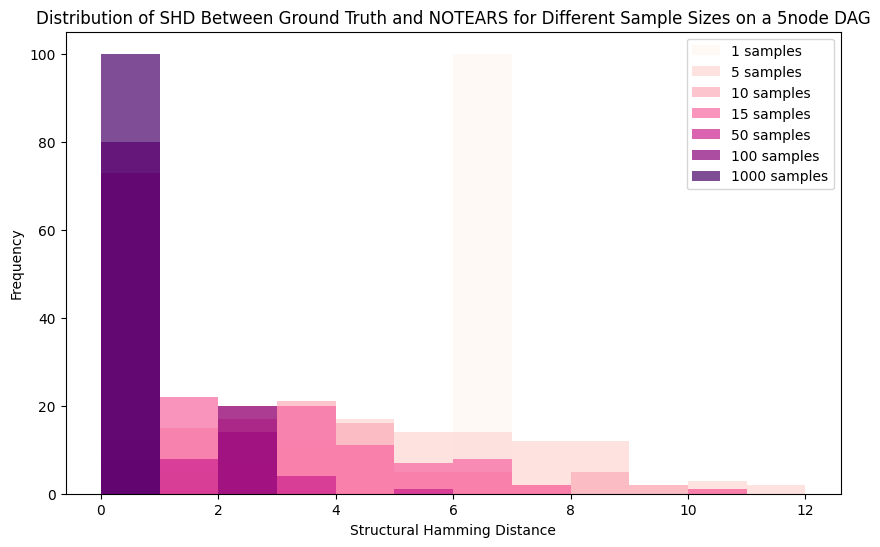

In [16]:
# Run experiments with 10, 50, 100, 1000 samples and plot SHD
samplesize_experiment_labels = [1, 5, 10, 15, 50, 100, 1000]
n_reps = 100
samplesize_experiment_results = {}
ground_truth = np.array([[0, 0, 1, 0, 0],
                         [1, 0, 1, 1, 0],
                         [0 , 0, 0, 0, 1],
                         [0, 0, 0, 0, 1],
                         [0, 0, 0, 0, 0]])
d = len(ground_truth)

# Gradient colors from red to pink (manually interpolate or use colormaps)
from matplotlib.colors import to_hex
cmap = plt.get_cmap('RdPu')
colors = [to_hex(cmap(float(i) / (len(samplesize_experiment_labels) - 1))) for i in range(len(samplesize_experiment_labels))]

samplesize_experiment_results = {}

for idx, n_samples in enumerate(samplesize_experiment_labels):
    shd_results = []
    for rep in range(n_reps):
        X = simulate_linear_sem(ground_truth, n_samples, noise_scale=1.0)

        # Run NOTEARS
        G_est = notears_linear(X, lambda1=0.1, loss_type='l2')
        G_adj_est = (np.abs(G_est) > 1e-3).astype(int)

        G_graph = nx.DiGraph(ground_truth)
        G_est_graph = nx.DiGraph(G_adj_est)

        shd = cdt.metrics.SHD(G_graph, G_est_graph)
        shd_results.append(shd)
    samplesize_experiment_results[str(n_samples)] = shd_results

# Plot the histogram with gradient colors
plt.figure(figsize=(10, 6))
bins = np.arange(0, 13)  # Adjust bin range for your SHD values if needed
for idx, n_samples in enumerate(samplesize_experiment_labels):
    plt.hist(samplesize_experiment_results[str(n_samples)], 
             bins=bins, 
             alpha=0.7, 
             color=colors[idx], 
             label=f'{n_samples} samples')
plt.xlabel('Structural Hamming Distance')
plt.ylabel('Frequency')
plt.title('Distribution of SHD Between Ground Truth and NOTEARS for Different Sample Sizes on a ' + str(d) + ' node DAG')
plt.legend()
plt.show()

In [7]:
def samplesize_experiment(samplesize_experiment_labels, n_reps, ground_truth, noise_fn=None, noise_scale=1.0):

    samplesize_experiment_results = {}
    d = len(ground_truth)
    
    # Gradient colors from red to pink (manually interpolate or use colormaps)
    from matplotlib.colors import to_hex
    cmap = plt.get_cmap('RdPu')
    colors = [to_hex(cmap(float(i) / (len(samplesize_experiment_labels) - 1))) for i in range(len(samplesize_experiment_labels))]
        
    for idx, n_samples in enumerate(samplesize_experiment_labels):
        shd_results = []
        for rep in range(n_reps):
            X = simulate_linear_sem(ground_truth, n_samples, noise_scale=noise_scale, noise_fn=noise_fn)
    
            # Run NOTEARS
            G_est = notears_linear(X, lambda1=0.1, loss_type='l2')
            G_adj_est = (np.abs(G_est) > 1e-3).astype(int)
    
            G_graph = nx.DiGraph(ground_truth)
            G_est_graph = nx.DiGraph(G_adj_est)
    
            shd = cdt.metrics.SHD(G_graph, G_est_graph)
            shd_results.append(shd)
        samplesize_experiment_results[str(n_samples)] = shd_results
    
    # Plot the histogram with gradient colors
    plt.figure(figsize=(10, 6))
    bins = np.arange(0, 13)  # Adjust bin range for your SHD values if needed
    for idx, n_samples in enumerate(samplesize_experiment_labels):
        plt.hist(samplesize_experiment_results[str(n_samples)], 
                 bins=bins, 
                 alpha=0.7, 
                 color=colors[idx], 
                 label=f'{n_samples} samples')
    plt.xlabel('Structural Hamming Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of SHD Between Ground Truth and NOTEARS for Different Sample Sizes on a ' + str(d) + ' node DAG')
    plt.legend()
    plt.show()

In [3]:
def laplace_noise(n, scale):
    #Return Laplace distributed white noise (i.e mean of 0)
    return np.random.laplace(loc=0.0, scale=scale, size=n)

def uniform_noise(n, scale):
    return np.random.uniform(low=-scale, high=scale, size=n)

def exponential_noise(n, scale):
    return np.random.exponential(scale=scale, size=n)

Laplacian Noise


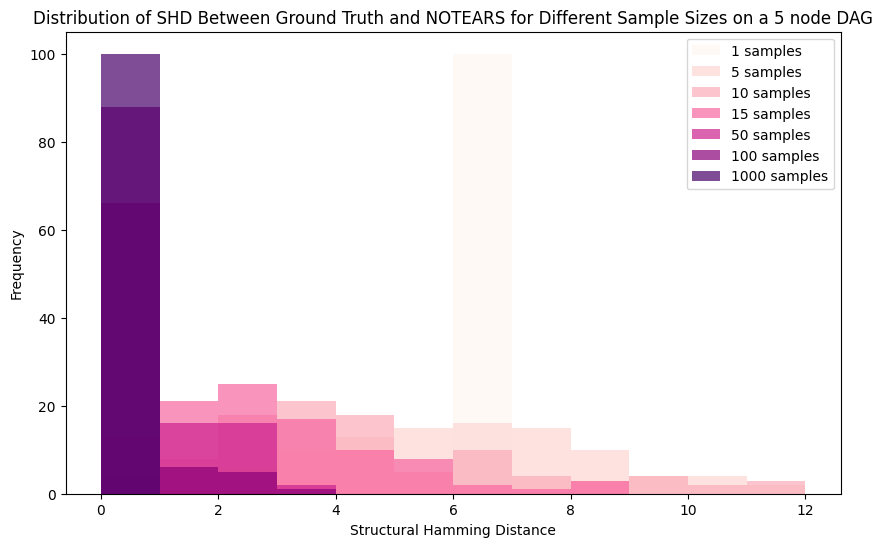

Uniform Noise


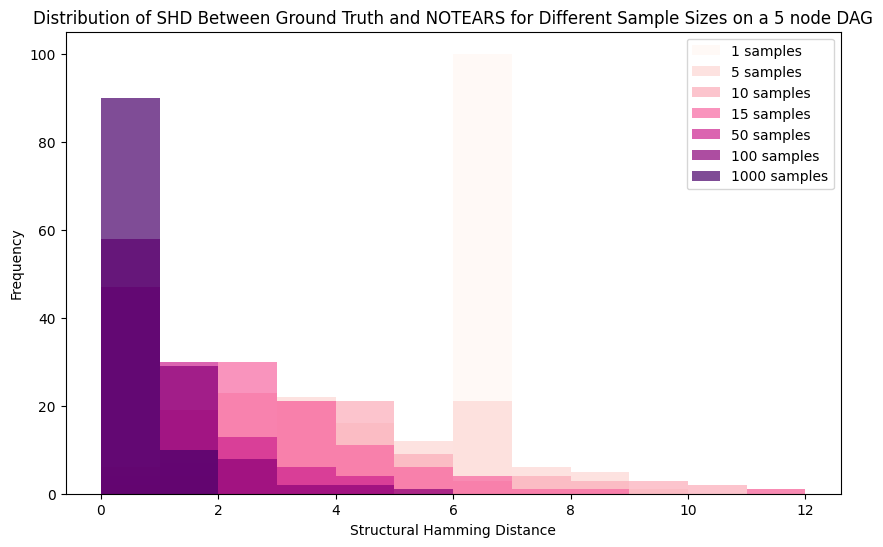

Exponential Noise


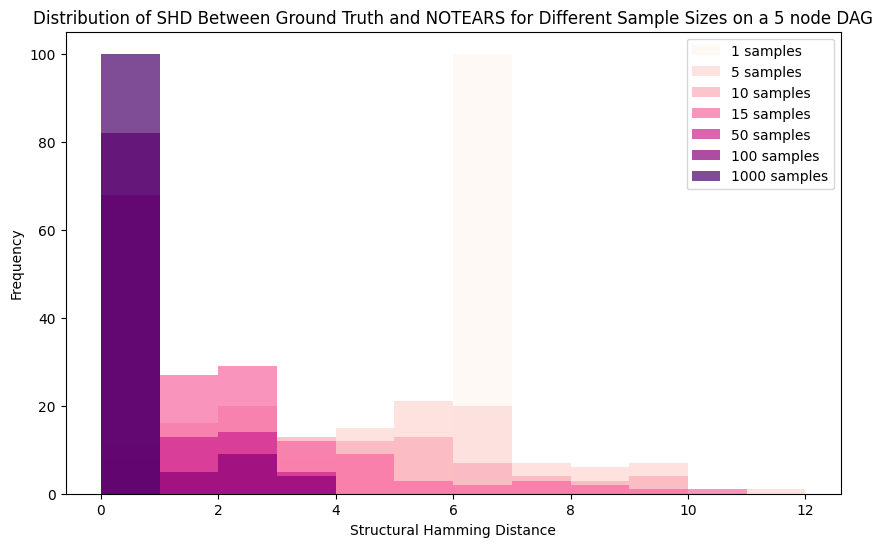

In [10]:
samplesize_experiment_labels = [1, 5, 10, 15, 50, 100, 1000]
n_reps = 100
ground_truth = np.array([[0, 0, 1, 0, 0],
                         [1, 0, 1, 1, 0],
                         [0 , 0, 0, 0, 1],
                         [0, 0, 0, 0, 1],
                         [0, 0, 0, 0, 0]])

print("Laplacian Noise")
samplesize_experiment(samplesize_experiment_labels, n_reps, ground_truth, laplace_noise)

print("Uniform Noise")
samplesize_experiment(samplesize_experiment_labels, n_reps, ground_truth, uniform_noise)

print("Exponential Noise")
samplesize_experiment(samplesize_experiment_labels, n_reps, ground_truth, exponential_noise)

Breaking NOTEARS with DAGs on more vertices

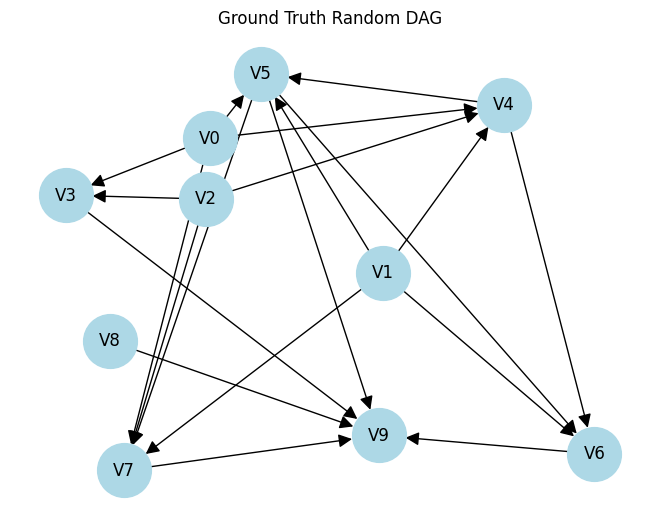

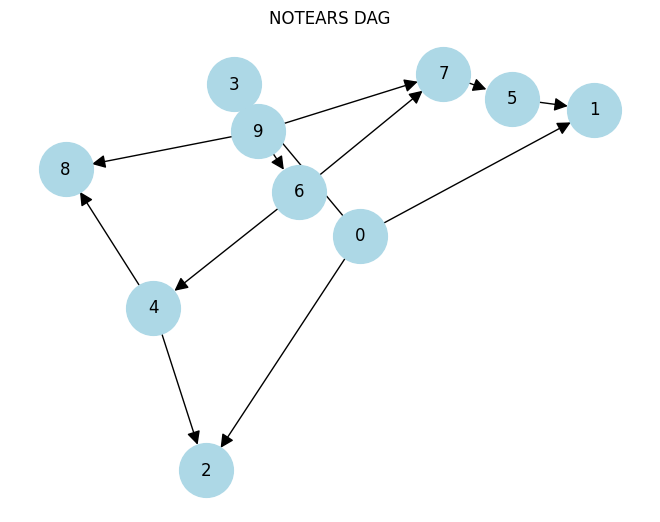

Graph Edit Distance: 13.0
SHD: 29


In [5]:
from cdt.data import AcyclicGraphGenerator
generator = AcyclicGraphGenerator('linear', npoints=500, nodes=10)
data, graph = generator.generate()

plot_graph(graph, "Ground Truth Random DAG")

# Run NOTEARS
data_np = data.values
G_est = notears_linear(data_np, lambda1=0.1, loss_type='l2')

# Threshold small weights to force adjacency matrix
G_adj_est = (np.abs(G_est) > 1e-3).astype(int)
G_est_graph = nx.DiGraph(G_adj_est)

plot_graph(G_est_graph, "NOTEARS DAG")
ged = nx.graph_edit_distance(graph, G_est_graph)
shd = cdt.metrics.SHD(graph, G_adj_est)
print("Graph Edit Distance: " + str(ged))
print("SHD: " + str(shd))

Noise scale of 10.0


overflow encountered in matmul
invalid value encountered in multiply


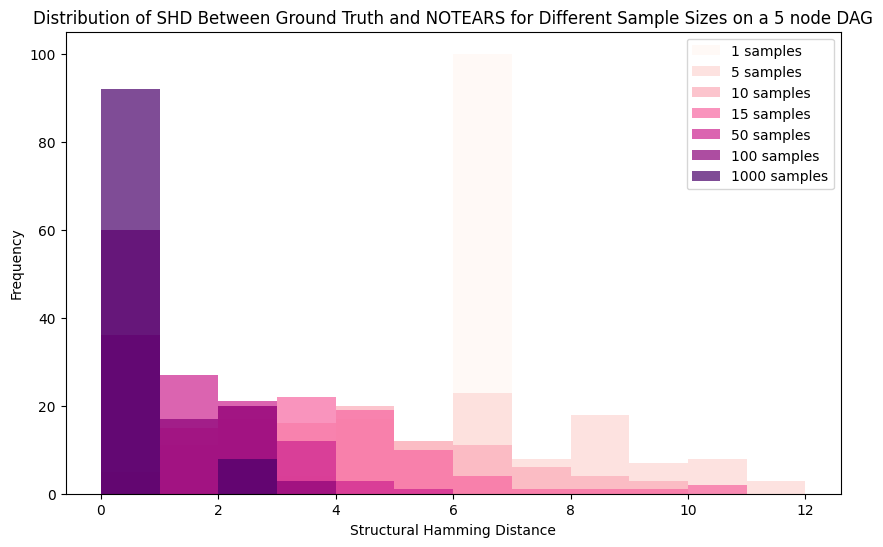

In [13]:
# super noisy 
samplesize_experiment_labels = [1, 5, 10, 15, 50, 100, 1000]
n_reps = 100
ground_truth = np.array([[0, 0, 1, 0, 0],
                         [1, 0, 1, 1, 0],
                         [0 , 0, 0, 0, 1],
                         [0, 0, 0, 0, 1],
                         [0, 0, 0, 0, 0]])
n_scale = 10.0

print("Noise scale of " + str(n_scale))
samplesize_experiment(samplesize_experiment_labels, n_reps, ground_truth, noise_scale = n_scale)

Noise scale of 25.0


overflow encountered in scalar multiply
overflow encountered in multiply


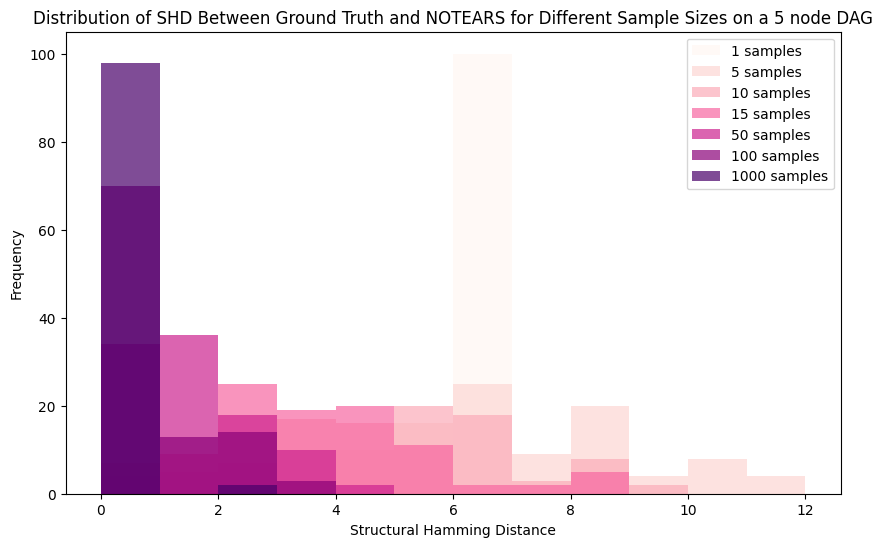

In [14]:
# super noisy 
samplesize_experiment_labels = [1, 5, 10, 15, 50, 100, 1000]
n_reps = 100
ground_truth = np.array([[0, 0, 1, 0, 0],
                         [1, 0, 1, 1, 0],
                         [0 , 0, 0, 0, 1],
                         [0, 0, 0, 0, 1],
                         [0, 0, 0, 0, 0]])
n_scale = 25.0

print("Noise scale of " + str(n_scale))
samplesize_experiment(samplesize_experiment_labels, n_reps, ground_truth, noise_scale = n_scale)

Noise scale of 100.0


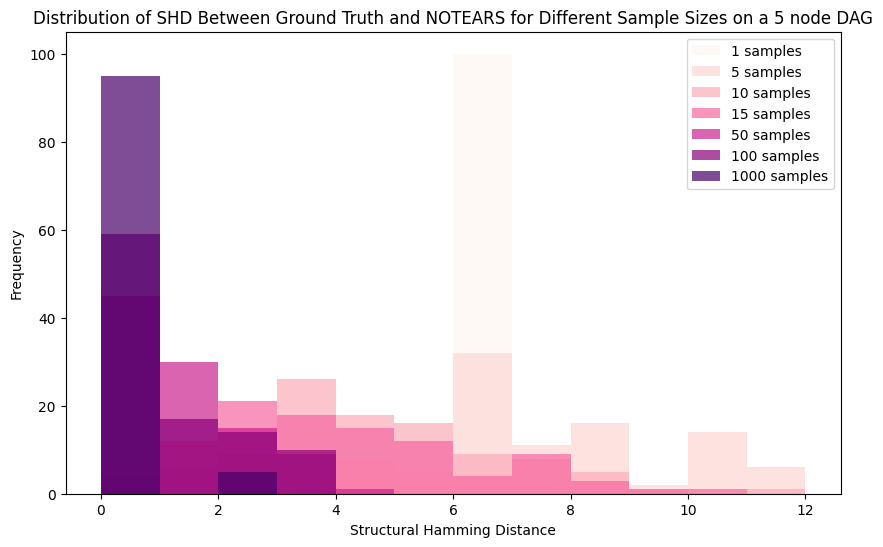

In [15]:
# super noisy 
samplesize_experiment_labels = [1, 5, 10, 15, 50, 100, 1000]
n_reps = 100
ground_truth = np.array([[0, 0, 1, 0, 0],
                         [1, 0, 1, 1, 0],
                         [0 , 0, 0, 0, 1],
                         [0, 0, 0, 0, 1],
                         [0, 0, 0, 0, 0]])
n_scale = 100.0

print("Noise scale of " + str(n_scale))
samplesize_experiment(samplesize_experiment_labels, n_reps, ground_truth, noise_scale = n_scale)